<a href="https://colab.research.google.com/github/hiomgupta/STT_Ai_L11/blob/main/22110174_A11_STT_Ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the datasets
train_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
test_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"

train_data = pd.read_csv(train_url, sep="\t")
test_data = pd.read_csv(test_url, sep="\t")

# Split train data into training and validation (80%/20%)
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(768, 512)  # Assuming input size is 768 (BERT embeddings)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)  # Output layer with 2 labels
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = MLPModel()
print(f"Trainable parameters: {count_parameters(model)}")


Trainable parameters: 566338


In [16]:
print("========== Model Summary ==========")
print(model)
print("\nTotal Trainable Parameters:", count_parameters(model))


========== Model Summary ==========
MLPModel(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)

Total Trainable Parameters: 566338


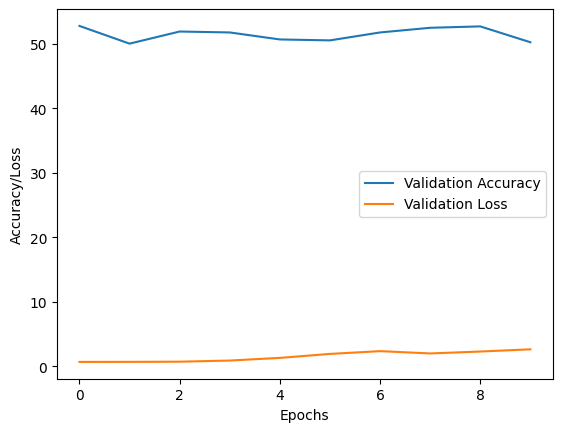

In [3]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Placeholder dataset (use actual preprocessed data here)
train_features = torch.randn((train_df.shape[0], 768))  # Example: size (num_samples, 768)
train_labels = torch.randint(0, 2, (train_df.shape[0],))  # Example binary labels

val_features = torch.randn((val_df.shape[0], 768))
val_labels = torch.randint(0, 2, (val_df.shape[0],))

# Prepare dataloaders
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_features, val_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model, loss, and optimizer
model = MLPModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
best_val_accuracy = 0
train_accuracies, val_accuracies, val_losses = [], [], []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'checkpoint.pt')

# Plot accuracy and loss
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()


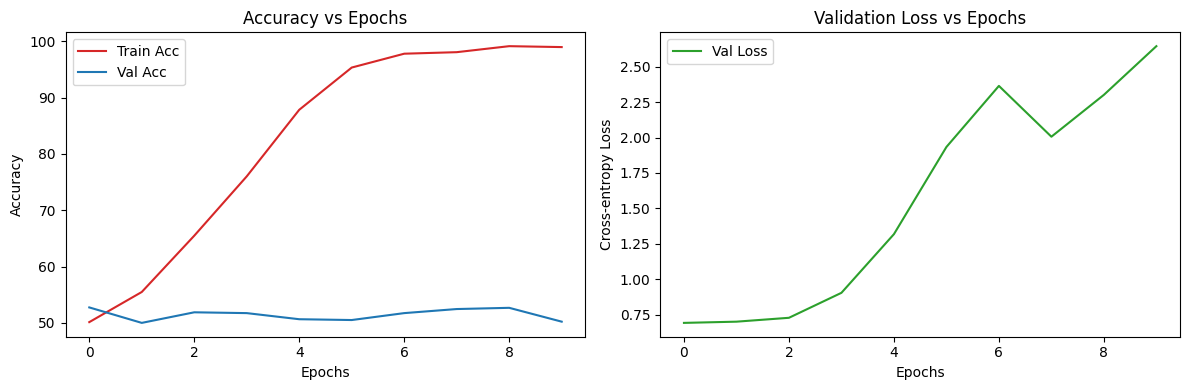

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# accuracy
ax1.plot(train_accuracies, label="Train Acc",  color="tab:red")
ax1.plot(val_accuracies,   label="Val Acc",    color="tab:blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy vs Epochs")
ax1.legend()

# validation loss
ax2.plot(val_losses, label="Val Loss", color="tab:green")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Cross‑entropy Loss")
ax2.set_title("Validation Loss vs Epochs")
ax2.legend()

plt.tight_layout()
plt.show()

## Quantisation

In [5]:
model_dynamic = torch.quantization.quantize_dynamic(
    model, {nn.Linear}, dtype=torch.qint8
)

# Save the quantized model
torch.save(model_dynamic.state_dict(), 'checkpoint_dynamic.pt')


In [6]:
model_half = model.half()

# Save the half-precision model
torch.save(model_half.state_dict(), 'checkpoint_half.pt')


In [7]:
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Safely check for float16 models
            try:
                param_dtype = next(model.parameters()).dtype
                if param_dtype == torch.float16:
                    inputs = inputs.half()
            except StopIteration:
                pass  # skip for quantized models with no parameters

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [8]:
val_accuracy_dynamic = evaluate_model(model_dynamic, val_loader)
val_accuracy_half = evaluate_model(model_half, val_loader)


In [12]:
def measure_inference_time(model, data_loader):
    import time
    model.eval()

    start_time = time.time()

    with torch.no_grad():
        for inputs, _ in data_loader:
            if hasattr(model, "parameters") and len(list(model.parameters())) > 0:
                if next(model.parameters()).dtype == torch.float16:
                    inputs = inputs.half()
            model(inputs)

    end_time = time.time()
    return (end_time - start_time) * 1000 / len(data_loader)  # in milliseconds


In [13]:
import os

# Measure inference times
original_time = measure_inference_time(model, val_loader)
dynamic_time = measure_inference_time(model_dynamic, val_loader)
half_time = measure_inference_time(model_half, val_loader)

# Measure model sizes
original_size = os.path.getsize("checkpoint.pt") / (1024 * 1024)  # MB
dynamic_size = os.path.getsize("checkpoint_dynamic.pt") / (1024 * 1024)  # MB
half_size = os.path.getsize("checkpoint_half.pt") / (1024 * 1024)  # MB

# Fill the table for accuracy, storage, and inference time
table = {
    "Model Name": ["Original", "Dynamic", "Half"],
    "Accuracy": [best_val_accuracy, val_accuracy_dynamic, val_accuracy_half],  # Replace with actual metrics
    "Storage (MB)": [original_size, dynamic_size, half_size],
    "Inference Time (ms)": [original_time, dynamic_time, half_time]
}

print(table)

{'Model Name': ['Original', 'Dynamic', 'Half'], 'Accuracy': [52.74566473988439, 50.216763005780344, 50.216763005780344], 'Storage (MB)': [2.163972854614258, 0.5496540069580078, 1.0838394165039062], 'Inference Time (ms)': [8.43281095678156, 1.9863085313276811, 12.067133730108088]}


In [14]:
import pandas as pd

# Create result table
results = {
    "Model Name": ["Original", "Dynamic", "Half"],
    "Accuracy (%)": [best_val_accuracy, val_accuracy_dynamic, val_accuracy_half],
    "Storage (MB)": [original_size, dynamic_size, half_size],
    "Inference Time (ms)": [original_time, dynamic_time, half_time]
}

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


Model Name  Accuracy (%)  Storage (MB)  Inference Time (ms)
  Original     52.745665      2.163973             8.432811
   Dynamic     50.216763      0.549654             1.986309
      Half     50.216763      1.083839            12.067134
